# Border Classifier Training

In [1]:
from src.data.ParkingProvider import NoSpacesException, NoImageException
from src.metrics.PerformanceMetricsProviderSklearn import PerformanceMetricsProviderSklearn
from src.metrics.entity.PerformanceMetrics import PerformanceMetrics
from src.detector.entity.DetectionParams import DetectionParams
from src.data.ParkingProviderLocal import ParkingProviderLocalParams,ParkingProviderLocal
from src.app.ParkingOccupancyProcessorLocal import ParkingOccupancyProcessorLocal
from src.detector.OccupancyDetectorDiff import OccupancyDetectorDiff
import pandas as pd
import cv2 as cv
import os
import pickle

# metrics_list = list()
# row_names = list()
random_seed = 1
# random_seed = datetime.now().timestamp
 
def test_parking(parking_id, weather, detection_params:DetectionParams, process_batch=True, training=False):
    metrics_provider: PerformanceMetricsProviderSklearn = PerformanceMetricsProviderSklearn()

    training_test_folder = 'training' if training else 'test'
    provider_params = ParkingProviderLocalParams(
    parking_id=parking_id, path=f'E:\\OneDrive - UNIVERSIDAD DE HUELVA\\TFG\\VisionParkDetect\\dataset\\{training_test_folder}\\{parking_id}\\{weather}')
    
    processor = ParkingOccupancyProcessorLocal(
        parking_provider_params=provider_params, detection_params=detection_params, performance_metrics_provider=metrics_provider)

    detection_params.parking_id = parking_id
    detection_params.weather = weather
    
    if process_batch:
        if training:
            try:
                return processor.process_batch_training(10)
            except (NoSpacesException, NoImageException) as ex:
                print(f"Finished processing training samples: ", ex)
        else:
            try:
                detection_params.show_imshow=False
                processor.process_batch(10)
            except (NoSpacesException, NoImageException) as ex:
                print(f"Finished processing samples: ", ex)

    else:
        while True:
            try:
                detection_params.show_imshow=True
                processor.process()
            except (NoSpacesException, NoImageException) as ex:
                print(f"Finished processing samples: ", ex)
                break
        
    if not training:
        metrics_provider.calculate_metrics()
        plot = not training
        metrics_provider.show_confusion_matrix(plot)

        return metrics_provider.metrics
    # metrics_list.append(metrics_provider.metrics)
    # row_names.append(row_name)
    
def test_vacant_threshold(parking_id, weather, detection_params:DetectionParams, at_blockSize_list, vacant_threshold_list, training=False):
    detection_params.weather = weather
    metrics_dict = dict()
    
    for vacant_threshold in vacant_threshold_list:
        metrics_dict_diff = dict()
        
        for at_blockSize in at_blockSize_list:    
            row_name = f'{parking_id}-{weather} vt={vacant_threshold} at_blockSize={at_blockSize}'
            print('Testing ', row_name)
            
            detection_params.vacant_threshold = vacant_threshold
            detection_params.at_blockSize = at_blockSize
            metrics = test_parking(parking_id, weather, detection_params, True, training)
            
            metrics_dict_diff[at_blockSize] = metrics

        metrics_dict[vacant_threshold] = metrics_dict_diff
         
    return metrics_dict

def training_vacant_threshold(parking_id, weather, detection_params:DetectionParams, at_blockSize_list):
    detection_params.weather = weather
    metrics_dict_diff = dict()
        
    for at_blockSize in at_blockSize_list:    
        row_name = f'Training {parking_id}-{weather} at_blockSize={at_blockSize}'
        print('Testing ', row_name)
        detection_params.at_blockSize = at_blockSize
        metrics = test_parking(parking_id, weather, detection_params, True, training=True)
        
        metrics_dict_diff[at_blockSize] = metrics

         
    return metrics_dict_diff
    # PerformanceMetricsProviderSklearn.show_dataframe(metrics_list, row_names)
        
# def setup_params(parking_id, weather, initial_params:DetectionParams=None):
   
#     provider_params = ParkingProviderLocalParams(
#         parking_id=parking_id, path=f'E:\\Documents\\PKLot\\PKLot\\PKLot\\PKLot\\{parking_id}\\{weather}', k=200)

#     parking_provider = ParkingProviderLocal(provider_params)

#     # metrics: PerformanceMetricsProviderSklearn = PerformanceMetricsProviderSklearn()

#     # processor = ParkingOccupancyProcessorLocal(
#     #     parking_provider_params=provider_params, detection_params=PARAMS_UFPR04, performance_metrics_provider=metrics)

#     try:
#         params = initial_params
#         while True:
#         # while (it > 0 and i < it) or it < 0:
#         #     i = i+1
#         #     print(f"Processing sample: {str(i)}")
#         #     processor.process()

#             parking = parking_provider.get_parking()
#             img = parking.image
#             spaces = parking.spaces

#             params = OccupancyDetectorDiff.setup_params_img(img, parking_id, weather, spaces, params)

#             cv.namedWindow("Press ESC to exit, other key to continue")
#             key = cv.waitKey(0)
#             if key == 27:
#                 cv.destroyAllWindows()
#                 break  
              
#             cv.destroyAllWindows()
   
#     except (NoSpacesException, NoImageException) as ex:
#         print(f"Finished processing: ", ex)
#     finally:
#         return params
    
def calculate_metrics(parking_id, weather_list, at_blockSize_list,  params=DetectionParams(), training=True, show_metrics=True, save_fig_dst=None):
    training_test_folder = 'training' if training else 'test'

    for weather in weather_list:
        
        file_pickle = f"test/bordersDetector/metrics_dict_vt_{parking_id}_{weather}_{training_test_folder}.pickle"
        if not os.path.exists(file_pickle):
            metrics_diff_dict = training_vacant_threshold(parking_id, weather, params, at_blockSize_list)
        else:
            with open(file_pickle, 'rb') as f:
                print(file_pickle)
                metrics_diff_dict = pickle.load(f)
                
        # Saving the objects:   
        if not os.path.exists(file_pickle):
            f= open(file_pickle, 'wb')
            pickle.dump(metrics_diff_dict, f)


        if show_metrics and save_fig_dst is not None :
            fig_dst = save_fig_dst + f'{parking_id}_{weather}_{training_test_folder}.png'
            PerformanceMetricsProviderSklearn.show_tpr_fpr(metrics_diff_dict, show_diff=False, save_fig_dst=fig_dst)

            
    
    
def transpose_dict(dictionary):
    transposed_dict = {}
    for vacant_threshold, inner_dict in dictionary.items():
        for block_size, metrics in inner_dict.items():
            if block_size not in transposed_dict:
                transposed_dict[block_size] = {}
            transposed_dict[block_size][vacant_threshold] = metrics
    return transposed_dict

def choose_training_parameters(parking_id) -> pd.DataFrame:
    weather_dict = dict()
    weather_list = ['Sunny', 'Cloudy', 'Rainy']
    training = True
    training_test_folder = 'training' if training else 'test'

    for weather in weather_list:

        file_pickle = f"test/bordersDetector/metrics_dict_vt_{parking_id}_{weather}_{training_test_folder}.pickle"

        with open(file_pickle, 'rb') as f:
            print(file_pickle)
            metrics_dict_vt = pickle.load(f)
            
            weather_dict[weather] = metrics_dict_vt
            
    df = PerformanceMetricsProviderSklearn.choose_parameters(weather_dict)
    df[['AUC', 'Dist',  "Precision", "Specificity", "Recall", "F1", "Accuracy"]] = df[['AUC', 'Dist',  "Precision", "Specificity", "Recall", "F1", "Accuracy"]].round(3)

    pd.set_option('display.max_rows', None)

    display(df)
    # Seleccionar fila con mayor F1 para cada weather
    best_rows = df.loc[df.groupby("Weather")["F1"].idxmax()]

    # Seleccionar la mejor fila global
    global_best_row = df.loc[df["F1"].idxmax()]

    print("Mejor fila por weather:")
    print(best_rows)
    print("\nMejor fila global:")
    print(global_best_row)
    
    return df

def test_parking_bs_vt(parking_id, blockSize, vacant_threshold, weather_list = ['Sunny', 'Cloudy', 'Rainy']):
    training = False
    training_str = 'Training' if training else 'Testing'
    save_dst = 'E:\\OneDrive - UNIVERSIDAD DE HUELVA\\TFG\\VisionParkDetect\\test\\bordersDetector\\'
    detection_params=DetectionParams()
    detection_params.at_method = cv.ADAPTIVE_THRESH_GAUSSIAN_C
    detection_params.at_blockSize = blockSize
    detection_params.vacant_threshold = vacant_threshold
    testing_metrics = dict()

    for weather in weather_list:
        row_name = f'{weather}-{training_str} bs={detection_params.at_blockSize} vt={detection_params.vacant_threshold}'
        print(row_name)
        testing_metrics[row_name]=test_parking(parking_id, weather, detection_params=detection_params, process_batch=True, training=training)
        print(testing_metrics[row_name].to_latex("Test", weather, detection_params.at_blockSize, detection_params.vacant_threshold))

In [3]:
dfs = list()

## UFPR04

### UFPR04 Training

test/bordersDetector/metrics_dict_vt_UFPR04_Sunny_training.pickle


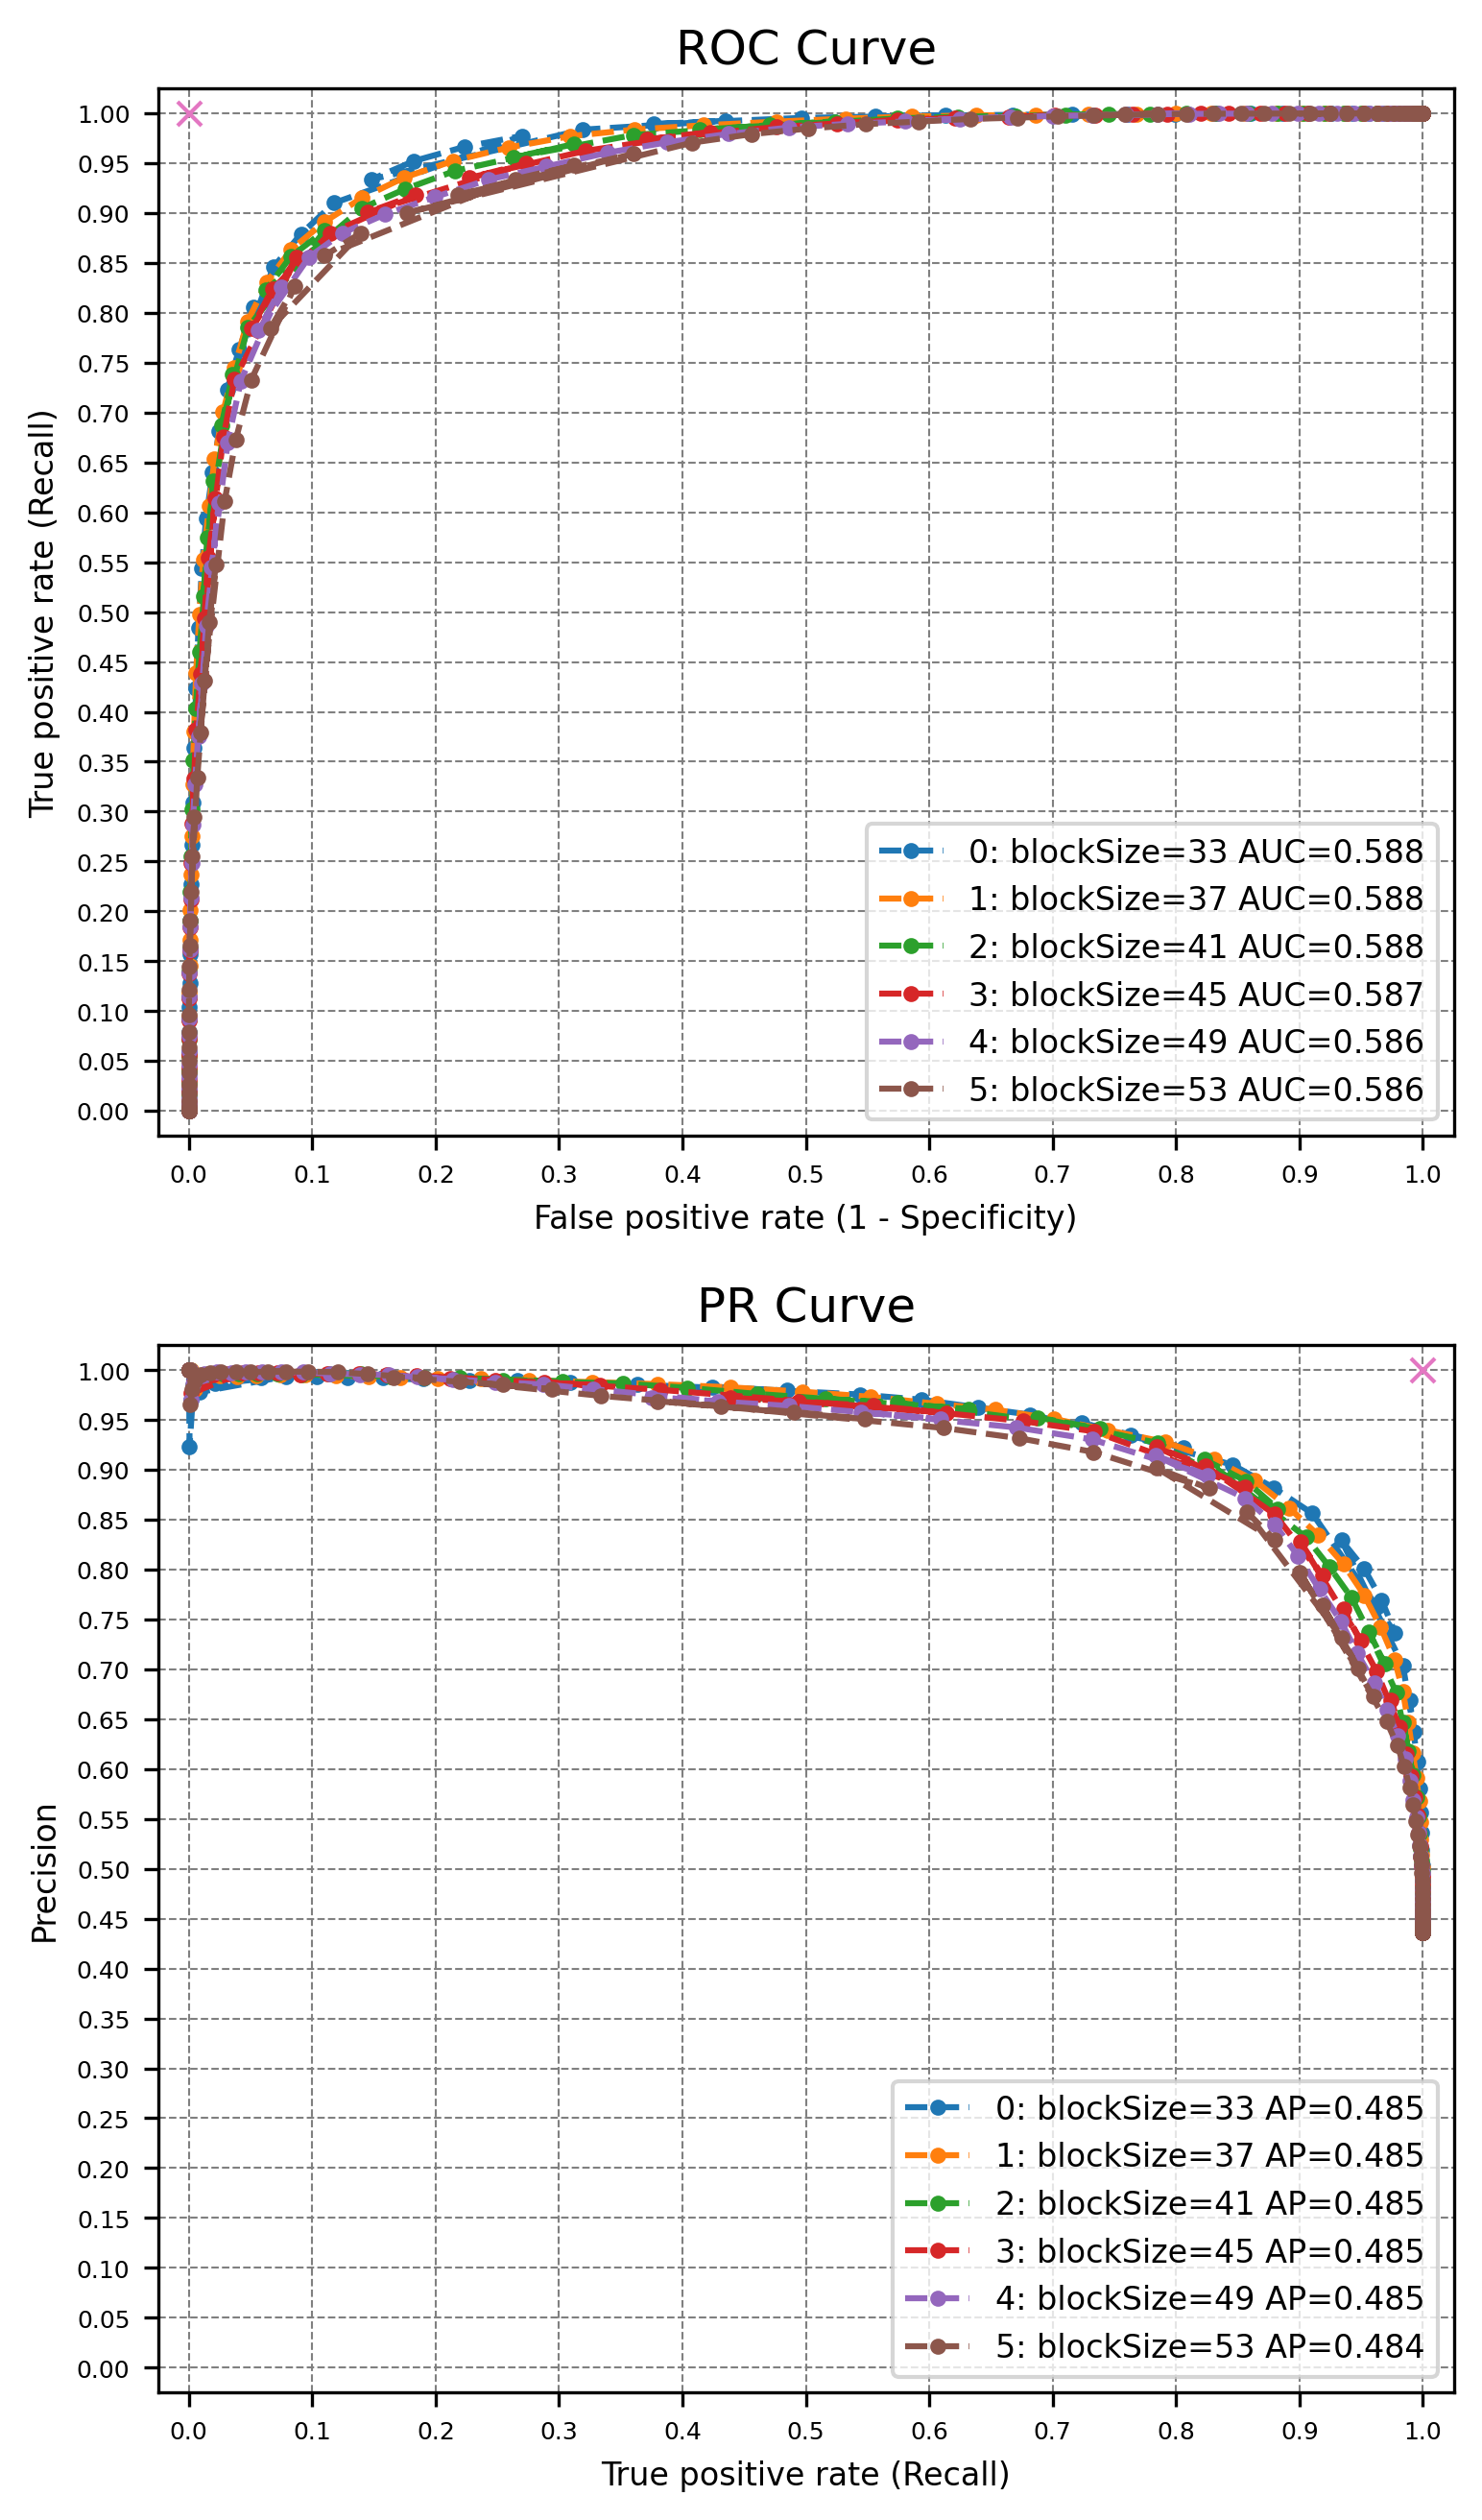

test/bordersDetector/metrics_dict_vt_UFPR04_Cloudy_training.pickle


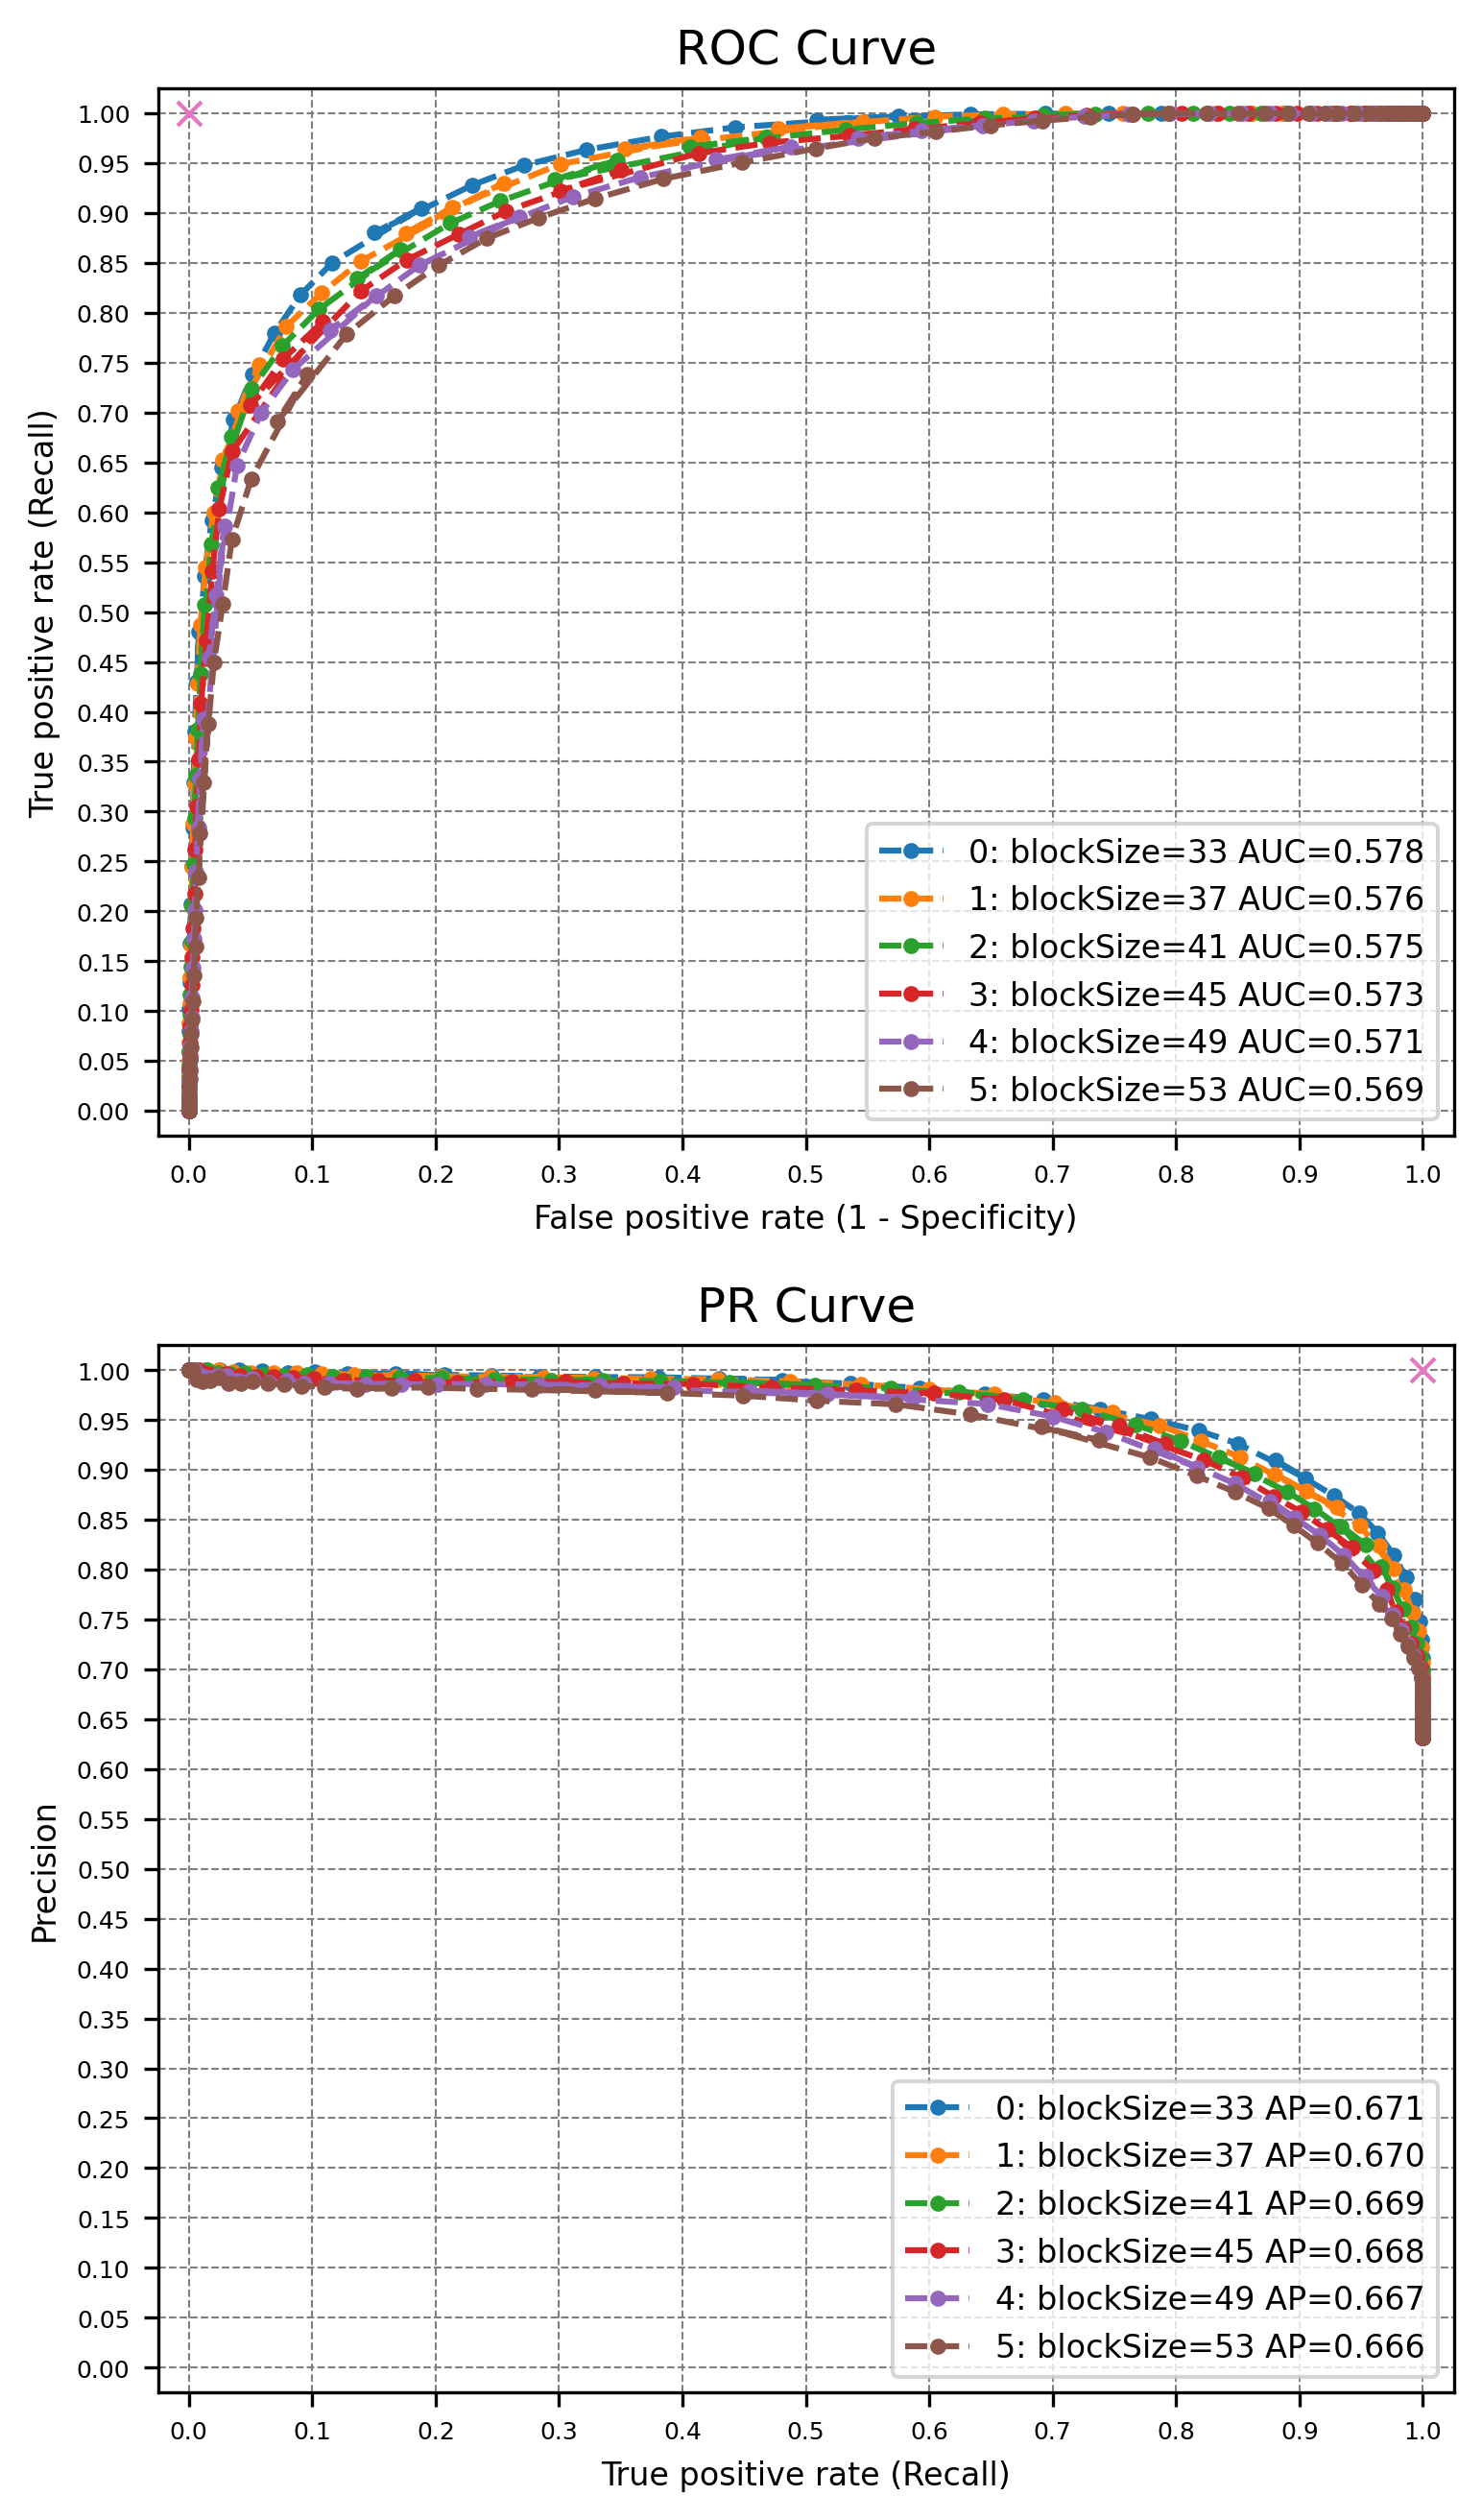

test/bordersDetector/metrics_dict_vt_UFPR04_Rainy_training.pickle


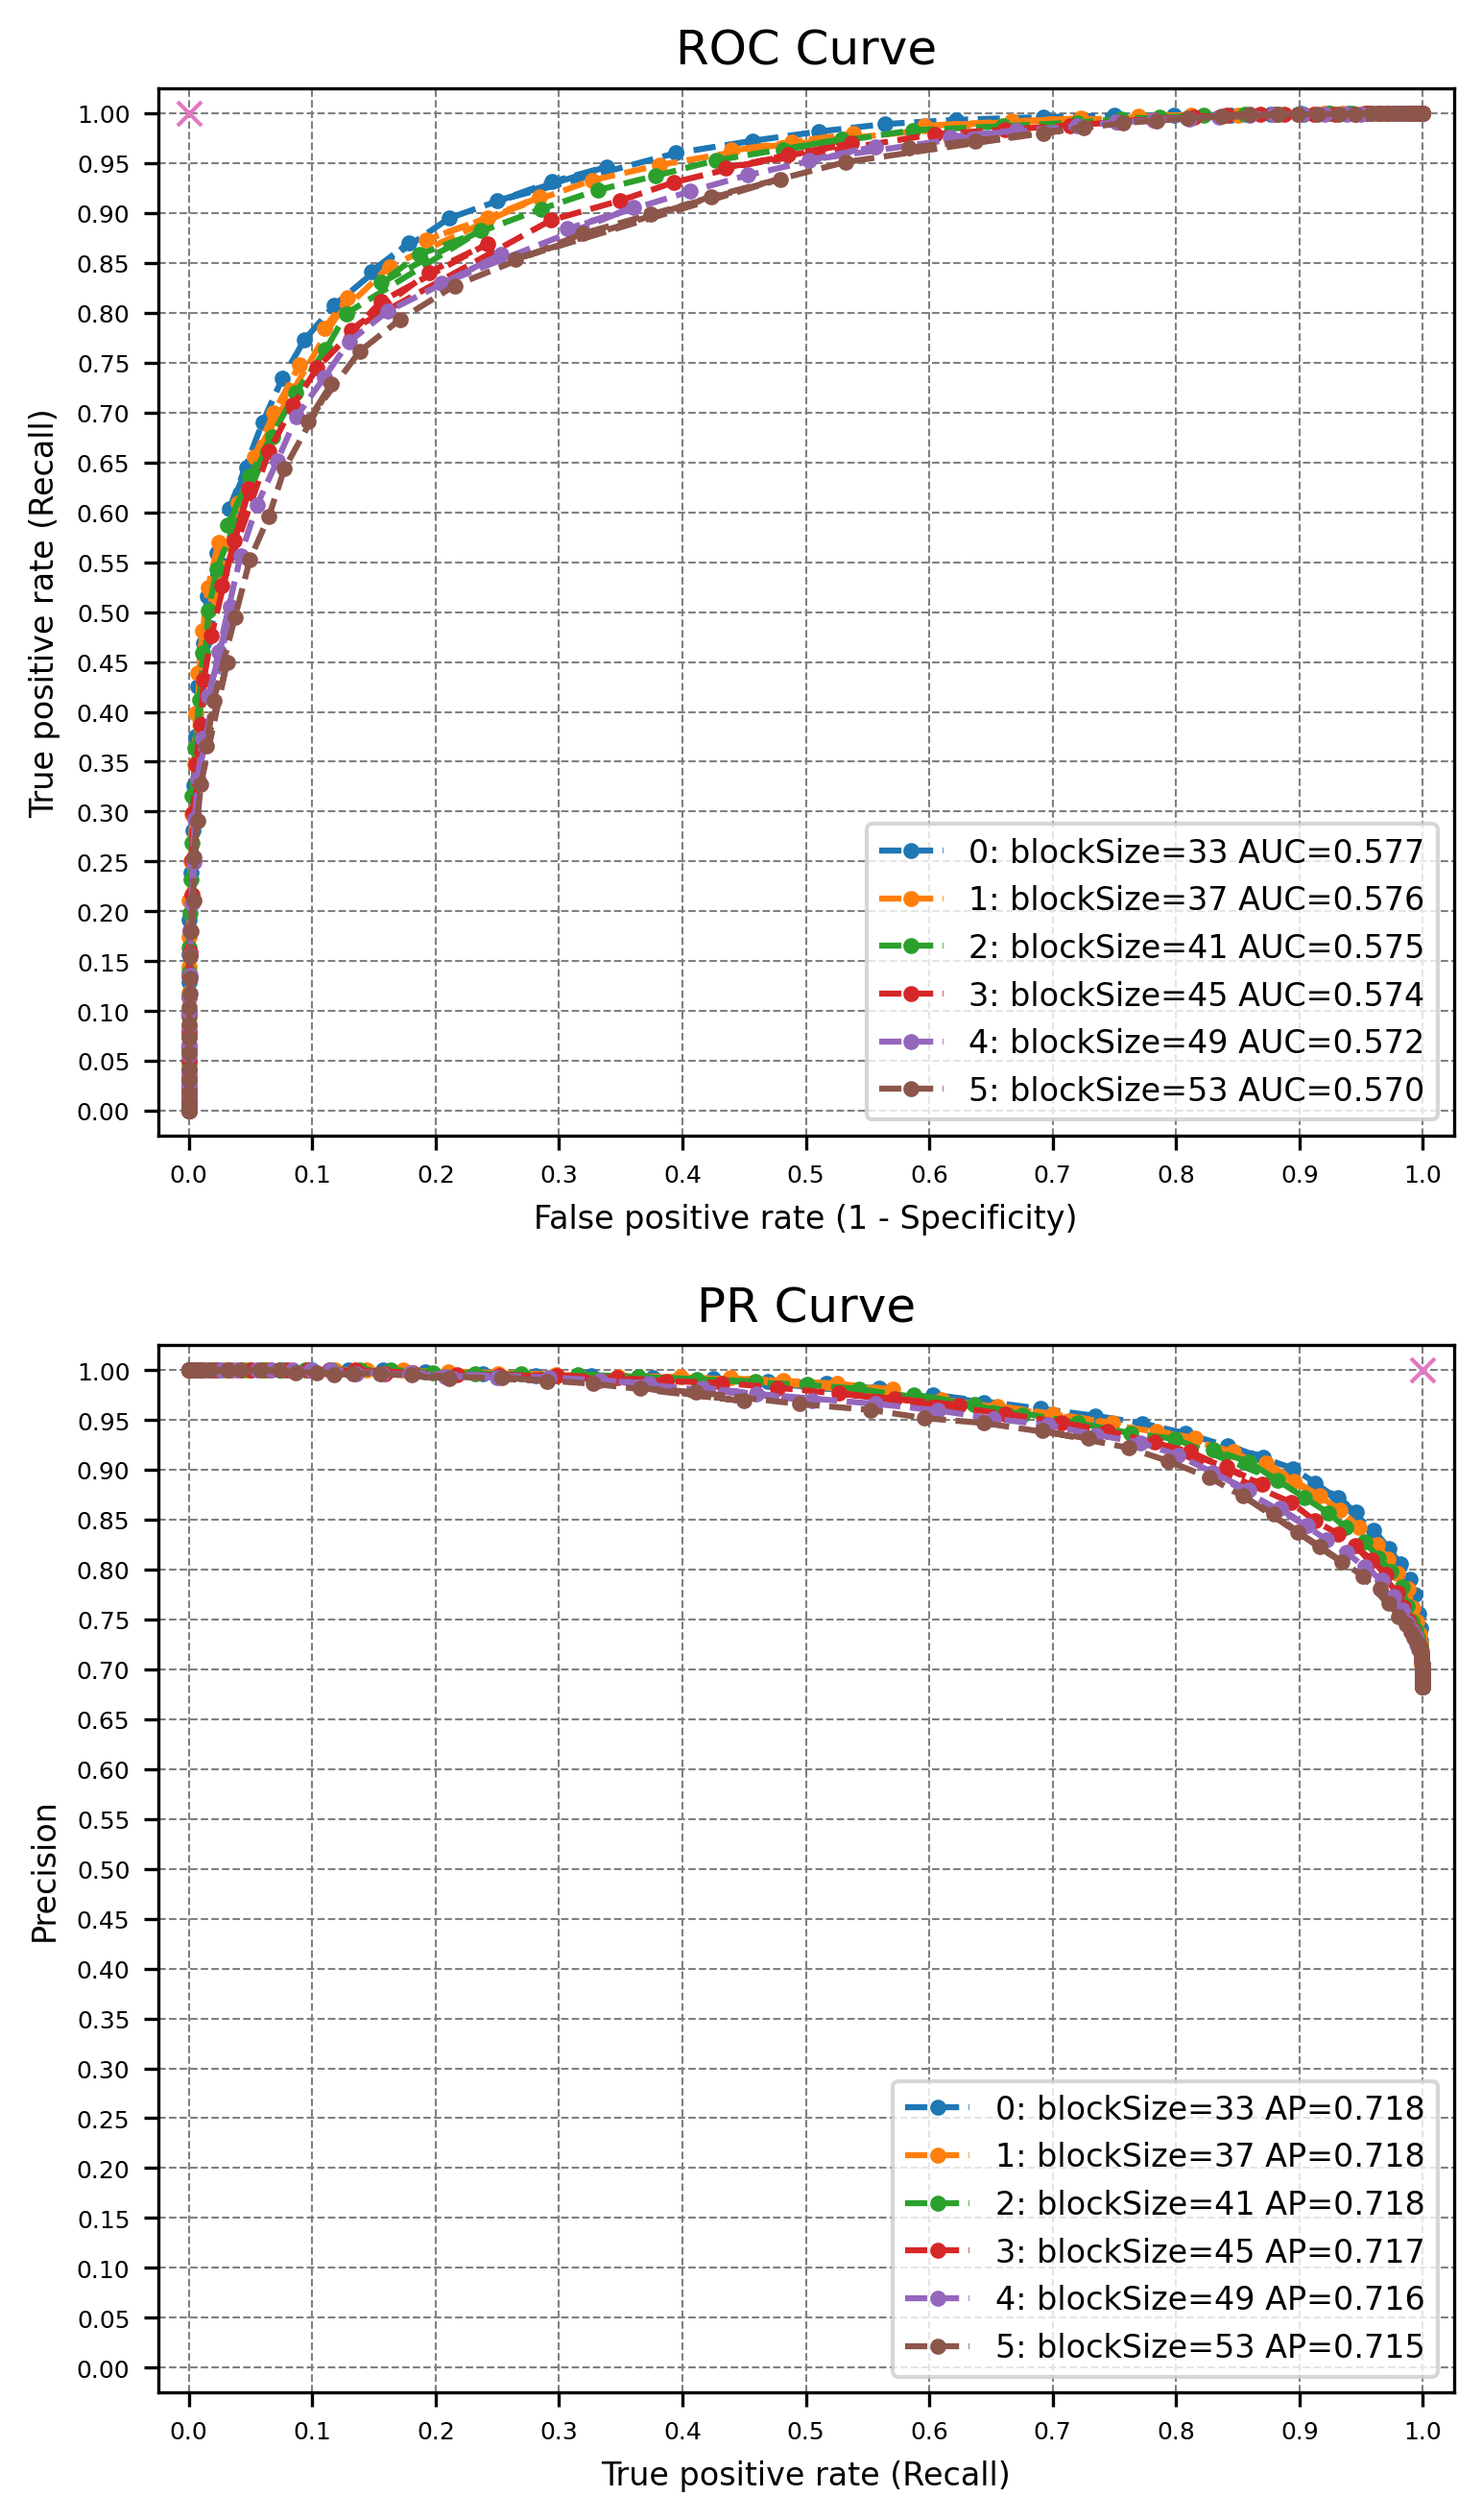

In [4]:
parking_id = 'UFPR04'

at_blockSize_list = [33,37,41,45,49,53]
weather_list = ['Sunny', 'Cloudy', 'Rainy']
training = True
save_dst = 'E:\\OneDrive - UNIVERSIDAD DE HUELVA\\TFG\\VisionParkDetect\\test\\bordersDetector\\'
params = DetectionParams()
params.at_method = cv.ADAPTIVE_THRESH_GAUSSIAN_C


training_test_folder = 'training' if training else 'test'
calculate_metrics(parking_id, weather_list, at_blockSize_list, params=params, training=training, show_metrics=True, save_fig_dst=save_dst)

### UFPR04 Training Choose Parameters

In [4]:
dfs.append(choose_training_parameters('UFPR04'))

test/bordersDetector/metrics_dict_vt_UFPR04_Sunny_training.pickle
test/bordersDetector/metrics_dict_vt_UFPR04_Cloudy_training.pickle
test/bordersDetector/metrics_dict_vt_UFPR04_Rainy_training.pickle
Training & Sunny & 33 & 0.3 & 0.856 & 0.882 & 0.910 & 0.883 & 0.894
Training & Sunny & 33 & 0.29 & 0.882 & 0.909 & 0.879 & 0.881 & 0.896
Training & Cloudy & 33 & 0.3 & 0.909 & 0.849 & 0.881 & 0.895 & 0.869
Training & Cloudy & 33 & 0.31 & 0.892 & 0.812 & 0.905 & 0.898 & 0.871
Training & Rainy & 33 & 0.3 & 0.901 & 0.789 & 0.895 & 0.898 & 0.861
Training & Rainy & 33 & 0.31 & 0.887 & 0.750 & 0.912 & 0.899 & 0.861


,Weather,bs,vt,AUC,Dist Curve,Dist,Precision,Specificity,Recall,F1,Accuracy
0,Sunny,33,0.30,0.588,ROC,0.148,0.856,0.882,0.910,0.883,0.894
1,Sunny,33,0.29,0.588,PR,0.169,0.882,0.909,0.879,0.881,0.896
2,Cloudy,33,0.30,0.578,ROC,0.148,0.909,0.849,0.881,0.895,0.869
3,Cloudy,33,0.31,0.578,PR,0.144,0.892,0.812,0.905,0.898,0.871
4,Rainy,33,0.30,0.577,ROC,0.148,0.901,0.789,0.895,0.898,0.861
5,Rainy,33,0.31,0.577,PR,0.143,0.887,0.750,0.912,0.899,0.861


Mejor fila por weather:
  Weather  bs    vt    AUC Dist Curve   Dist  Precision  Specificity  Recall  \
3  Cloudy  33  0.31  0.578         PR  0.144      0.892        0.812   0.905   
5   Rainy  33  0.31  0.577         PR  0.143      0.887        0.750   0.912   
0   Sunny  33  0.30  0.588        ROC  0.148      0.856        0.882   0.910   

      F1  Accuracy  
3  0.898     0.871  
5  0.899     0.861  
0  0.883     0.894  

Mejor fila global:
Weather        Rainy
bs                33
vt              0.31
AUC            0.577
Dist Curve        PR
Dist           0.143
Precision      0.887
Specificity     0.75
Recall         0.912
F1             0.899
Accuracy       0.861
Name: 5, dtype: object


In [ ]:
data = [
    ["PUCPR", "Sunny", 1843, 184300, 471, 47100],
    ["PUCPR", "Cloudy", 1059, 105900, 269, 26900],
    ["PUCPR", "Rainy", 662, 66200, 169, 16900],
    ["UFPR04", "Sunny", 1669, 46732, 429, 12012],
    ["UFPR04", "Cloudy", 1120, 31360, 288, 8064],
    ["UFPR04", "Rainy", 224, 6272, 61, 1708],
    ["UFPR05", "Sunny", 1989, 89505, 511, 22995],
    ["UFPR05", "Cloudy", 1133, 50985, 293, 13185],
    ["UFPR05", "Rainy", 177, 7965, 49, 2205]
]

for row in data:
    total_training = row[3]
    total_testing = row[5]
    percentage_training = round((total_training / (total_training + total_testing)) * 100,1)
    percentage_testing = round((total_testing / (total_training + total_testing)) * 100,1)
    print(f"{row[0]} - {row[1]}: Training ({percentage_training}\%) ({total_training}), Testing ({percentage_testing}\%) ({total_testing})")


### UFPR04 Testing

Sunny-Testing bs=33 vt=0.31
Using OccupancyDetectorBorders
Selected 429 files
Processing 429 files with 10 workers


100%|██████████| 429/429 [01:11<00:00,  6.02it/s]

Precision: 0.832
specificity: 0.814
Recall: 0.934
F1 Score: 0.880
Accuracy: 0.874


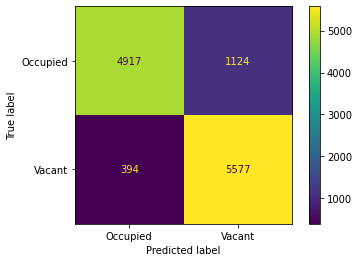

Test & Sunny & 33 & 0.31 & 0.832 & 0.814 & 0.934 & 0.880 & 0.874
Cloudy-Testing bs=33 vt=0.31
Using OccupancyDetectorBorders
Selected 288 files
Processing 288 files with 10 workers


100%|██████████| 288/288 [00:51<00:00,  5.56it/s]

Precision: 0.910
specificity: 0.792
Recall: 0.901
F1 Score: 0.906
Accuracy: 0.869


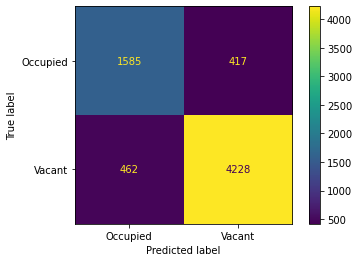

Test & Cloudy & 33 & 0.31 & 0.910 & 0.792 & 0.901 & 0.906 & 0.869
Rainy-Testing bs=33 vt=0.31
Using OccupancyDetectorBorders
Selected 61 files
Processing 61 files with 10 workers


100%|██████████| 61/61 [00:12<00:00,  4.89it/s]


Precision: 0.852
specificity: 0.796
Recall: 0.894
F1 Score: 0.873
Accuracy: 0.852


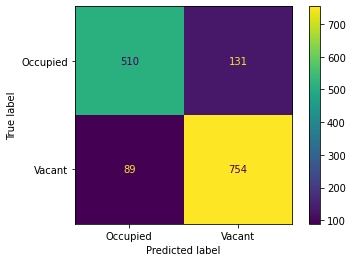

Test & Rainy & 33 & 0.31 & 0.852 & 0.796 & 0.894 & 0.873 & 0.852


In [6]:
parking_id = 'UFPR04'
training = False
training_str = 'Training' if training else 'Testing'
save_dst = 'E:\\OneDrive - UNIVERSIDAD DE HUELVA\\TFG\\VisionParkDetect\\test\\bordersDetector\\'
detection_params=DetectionParams()
detection_params.at_method = cv.ADAPTIVE_THRESH_GAUSSIAN_C
detection_params.at_blockSize = 33
detection_params.vacant_threshold = 0.31


weather_list = ['Sunny', 'Cloudy', 'Rainy']

testing_metrics = dict()

for weather in weather_list:
    row_name = f'{weather}-{training_str} bs={detection_params.at_blockSize} vt={detection_params.vacant_threshold}'
    print(row_name)
    testing_metrics[row_name]=test_parking(parking_id, weather, detection_params=detection_params, process_batch=True, training=training)
    print(testing_metrics[row_name].to_latex("Test", weather, detection_params.at_blockSize, detection_params.vacant_threshold))



## ufpr04 tESTING specialized

Sunny-Testing bs=33 vt=0.3
Using OccupancyDetectorBorders
Selected 429 files
Processing 429 files with 10 workers


100%|██████████| 429/429 [01:20<00:00,  5.30it/s]

Precision: 0.861
specificity: 0.854
Recall: 0.910
F1 Score: 0.885
Accuracy: 0.882


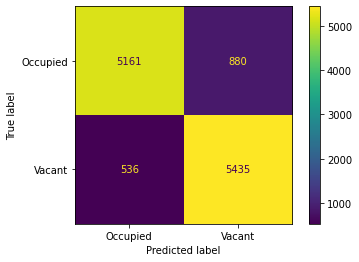

Test & Sunny & 33 & 0.3 & 0.861 & 0.854 & 0.910 & 0.885 & 0.882
Cloudy-Testing bs=33 vt=0.31
Using OccupancyDetectorBorders
Selected 288 files
Processing 288 files with 10 workers


100%|██████████| 288/288 [01:00<00:00,  4.73it/s]


Precision: 0.910
specificity: 0.792
Recall: 0.901
F1 Score: 0.906
Accuracy: 0.869


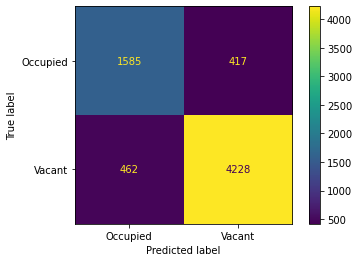

Test & Cloudy & 33 & 0.31 & 0.910 & 0.792 & 0.901 & 0.906 & 0.869
Rainy-Testing bs=33 vt=0.31
Using OccupancyDetectorBorders
Selected 61 files
Processing 61 files with 10 workers


100%|██████████| 61/61 [00:15<00:00,  4.00it/s]


Precision: 0.852
specificity: 0.796
Recall: 0.894
F1 Score: 0.873
Accuracy: 0.852


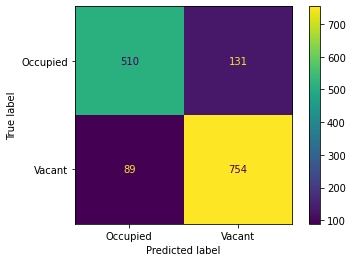

Test & Rainy & 33 & 0.31 & 0.852 & 0.796 & 0.894 & 0.873 & 0.852


In [8]:
test_parking_bs_vt('UFPR04', 33, 0.30, weather_list=['Sunny'])
test_parking_bs_vt('UFPR04', 33, 0.31, weather_list=['Cloudy'])
test_parking_bs_vt('UFPR04', 33, 0.31, weather_list=['Rainy'])

## UFPR05

### UPFR05 Training

In [ ]:
parking_id = 'UFPR05'

at_blockSize_list = [33,37,41,45,49,53]
weather_list = ['Sunny', 'Cloudy', 'Rainy']
training = True
save_dst = 'E:\\OneDrive - UNIVERSIDAD DE HUELVA\\TFG\\VisionParkDetect\\test\\bordersDetector\\'
params = DetectionParams()
params.at_method = cv.ADAPTIVE_THRESH_GAUSSIAN_C
params.median_k = -1


calculate_metrics(parking_id, weather_list, at_blockSize_list, params=params, training=training, show_metrics=True, save_fig_dst=save_dst)

### UFPR05 Training Choose Parameters

In [5]:
dfs.append(choose_training_parameters('UFPR05'))

test/bordersDetector/metrics_dict_vt_UFPR05_Sunny_training.pickle
test/bordersDetector/metrics_dict_vt_UFPR05_Cloudy_training.pickle
test/bordersDetector/metrics_dict_vt_UFPR05_Rainy_training.pickle
Training & Sunny & 53 & 0.36 & 0.841 & 0.875 & 0.883 & 0.861 & 0.878
Training & Sunny & 53 & 0.35 & 0.860 & 0.895 & 0.862 & 0.861 & 0.881
Training & Cloudy & 53 & 0.36 & 0.839 & 0.884 & 0.865 & 0.852 & 0.877
Training & Cloudy & 53 & 0.35 & 0.866 & 0.908 & 0.847 & 0.856 & 0.883
Training & Rainy & 53 & 0.35 & 0.797 & 0.898 & 0.893 & 0.843 & 0.896
Training & Rainy & 53 & 0.35 & 0.797 & 0.898 & 0.893 & 0.843 & 0.896


,Weather,bs,vt,AUC,Dist Curve,Dist,Precision,Specificity,Recall,F1,Accuracy
0,Sunny,53,0.36,0.596,ROC,0.171,0.841,0.875,0.883,0.861,0.878
1,Sunny,53,0.35,0.596,PR,0.196,0.860,0.895,0.862,0.861,0.881
2,Cloudy,53,0.36,0.589,ROC,0.171,0.839,0.884,0.865,0.852,0.877
3,Cloudy,53,0.35,0.589,PR,0.196,0.866,0.908,0.847,0.856,0.883
4,Rainy,53,0.35,0.601,ROC,0.148,0.797,0.898,0.893,0.843,0.896
5,Rainy,53,0.35,0.601,PR,0.196,0.797,0.898,0.893,0.843,0.896


Mejor fila por weather:
  Weather  bs    vt    AUC Dist Curve   Dist  Precision  Specificity  Recall  \
3  Cloudy  53  0.35  0.589         PR  0.196      0.866        0.908   0.847   
4   Rainy  53  0.35  0.601        ROC  0.148      0.797        0.898   0.893   
0   Sunny  53  0.36  0.596        ROC  0.171      0.841        0.875   0.883   

      F1  Accuracy  
3  0.856     0.883  
4  0.843     0.896  
0  0.861     0.878  

Mejor fila global:
Weather        Sunny
bs                53
vt              0.36
AUC            0.596
Dist Curve       ROC
Dist           0.171
Precision      0.841
Specificity    0.875
Recall         0.883
F1             0.861
Accuracy       0.878
Name: 0, dtype: object


### UFPR05 Testing

Sunny-Testing bs=53 vt=0.36
Using OccupancyDetectorBorders
Selected 511 files
Processing 511 files with 10 workers


100%|██████████| 511/511 [00:57<00:00,  8.95it/s]


Precision: 0.816
specificity: 0.868
Recall: 0.858
F1 Score: 0.837
Accuracy: 0.864


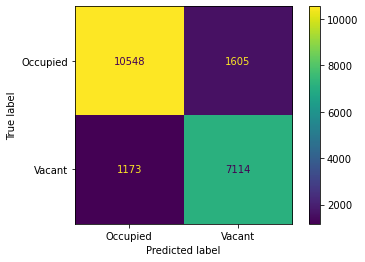

Cloudy-Testing bs=53 vt=0.36
Using OccupancyDetectorBorders
Selected 293 files
Processing 293 files with 10 workers


100%|██████████| 293/293 [00:34<00:00,  8.57it/s]


Precision: 0.812
specificity: 0.879
Recall: 0.816
F1 Score: 0.814
Accuracy: 0.854


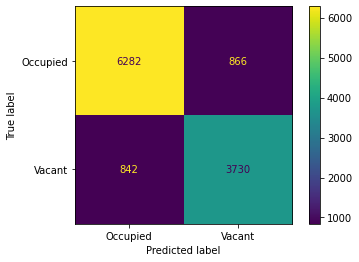

Rainy-Testing bs=53 vt=0.36
Using OccupancyDetectorBorders
Selected 49 files
Processing 49 files with 10 workers


100%|██████████| 49/49 [00:06<00:00,  7.47it/s]


Precision: 0.809
specificity: 0.894
Recall: 0.894
F1 Score: 0.850
Accuracy: 0.894


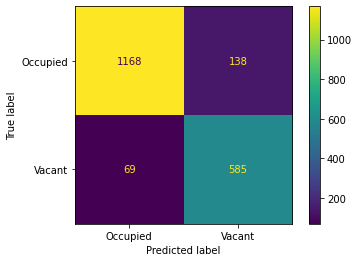

Test & Sunny & 53 & 0.36 & 0.816 & 0.868 & 0.858 & 0.837 & 0.864Test & Cloudy & 53 & 0.36 & 0.812 & 0.879 & 0.816 & 0.814 & 0.854Test & Rainy & 53 & 0.36 & 0.809 & 0.894 & 0.894 & 0.850 & 0.894


In [7]:
parking_id = 'UFPR05'
training = False
training_str = 'Training' if training else 'Testing'
save_dst = 'E:\\OneDrive - UNIVERSIDAD DE HUELVA\\TFG\\VisionParkDetect\\test\\bordersDetector\\'
detection_params=DetectionParams()
detection_params.at_method = cv.ADAPTIVE_THRESH_GAUSSIAN_C
detection_params.at_blockSize = 53
detection_params.vacant_threshold = 0.36

weather_list = ['Sunny', 'Cloudy', 'Rainy']
all_latex=""
testing_metrics = dict()

for weather in weather_list:
    row_name = f'{weather}-{training_str} bs={detection_params.at_blockSize} vt={detection_params.vacant_threshold}'
    print(row_name)
    testing_metrics[row_name]=test_parking(parking_id, weather, detection_params=detection_params, process_batch=True, training=training)
    all_latex += testing_metrics[row_name].to_latex("Test", weather, detection_params.at_blockSize, detection_params.vacant_threshold)

print(all_latex)

Sunny-Testing bs=53 vt=0.35
Using OccupancyDetectorBorders
Selected 511 files
Processing 511 files with 10 workers


100%|██████████| 511/511 [01:00<00:00,  8.41it/s]


Precision: 0.837
specificity: 0.888
Recall: 0.839
F1 Score: 0.838
Accuracy: 0.868


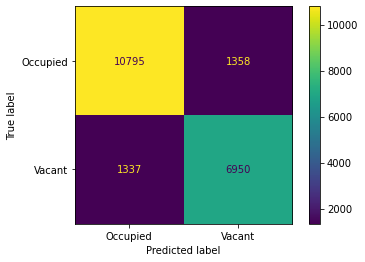

Test & Sunny & 53 & 0.35 & 0.837 & 0.888 & 0.839 & 0.838 & 0.868
Cloudy-Testing bs=53 vt=0.35
Using OccupancyDetectorBorders
Selected 293 files
Processing 293 files with 10 workers


100%|██████████| 293/293 [00:36<00:00,  8.07it/s]

Precision: 0.835
specificity: 0.899
Recall: 0.799
F1 Score: 0.816
Accuracy: 0.860


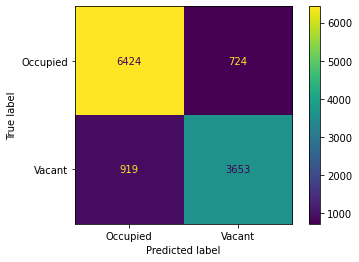

Test & Cloudy & 53 & 0.35 & 0.835 & 0.899 & 0.799 & 0.816 & 0.860
Rainy-Testing bs=53 vt=0.35
Using OccupancyDetectorBorders
Selected 49 files
Processing 49 files with 10 workers


100%|██████████| 49/49 [00:07<00:00,  6.98it/s]

Precision: 0.836
specificity: 0.914
Recall: 0.876
F1 Score: 0.856
Accuracy: 0.902


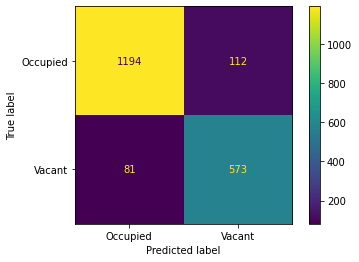

Test & Rainy & 53 & 0.35 & 0.836 & 0.914 & 0.876 & 0.856 & 0.902


In [6]:
test_parking_bs_vt('UFPR05', 53, 0.35, weather_list=['Sunny'])
test_parking_bs_vt('UFPR05', 53, 0.35, weather_list=['Cloudy'])
test_parking_bs_vt('UFPR05', 53, 0.35, weather_list=['Rainy'])

## PUCPR

### PUCPR Training

In [ ]:
parking_id = 'PUCPR'
at_blockSize_list = [33,37,41,45,49,53]
weather_list = ['Sunny','Cloudy','Rainy']
training = True
save_dst = 'E:\\OneDrive - UNIVERSIDAD DE HUELVA\\TFG\\VisionParkDetect\\test\\bordersDetector\\'
params = DetectionParams()
params.at_method = cv.ADAPTIVE_THRESH_GAUSSIAN_C

calculate_metrics(parking_id, weather_list, at_blockSize_list, params=params, training=training, show_metrics=True, save_fig_dst=save_dst)

### PUCPR Training Choose Parameters

In [6]:
dfs.append(choose_training_parameters('PUCPR'))

test/bordersDetector/metrics_dict_vt_PUCPR_Sunny_training.pickle
test/bordersDetector/metrics_dict_vt_PUCPR_Cloudy_training.pickle
test/bordersDetector/metrics_dict_vt_PUCPR_Rainy_training.pickle
Training & Sunny & 33 & 0.27 & 0.889 & 0.890 & 0.921 & 0.905 & 0.905
Training & Sunny & 33 & 0.27 & 0.889 & 0.890 & 0.921 & 0.905 & 0.905
Training & Cloudy & 33 & 0.31 & 0.971 & 0.938 & 0.947 & 0.959 & 0.944
Training & Cloudy & 33 & 0.32 & 0.964 & 0.920 & 0.964 & 0.964 & 0.950
Training & Rainy & 53 & 0.31 & 0.929 & 0.972 & 0.726 & 0.815 & 0.888
Training & Rainy & 53 & 0.32 & 0.909 & 0.962 & 0.746 & 0.819 & 0.889


,Weather,bs,vt,AUC,Dist Curve,Dist,Precision,Specificity,Recall,F1,Accuracy
0,Sunny,33,0.27,0.637,ROC,0.135,0.889,0.890,0.921,0.905,0.905
1,Sunny,33,0.27,0.637,PR,0.136,0.889,0.890,0.921,0.905,0.905
2,Cloudy,33,0.31,0.627,ROC,0.082,0.971,0.938,0.947,0.959,0.944
3,Cloudy,33,0.32,0.627,PR,0.051,0.964,0.920,0.964,0.964,0.950
4,Rainy,53,0.31,0.616,ROC,0.082,0.929,0.972,0.726,0.815,0.888
5,Rainy,53,0.32,0.616,PR,0.051,0.909,0.962,0.746,0.819,0.889


Mejor fila por weather:
  Weather  bs    vt    AUC Dist Curve   Dist  Precision  Specificity  Recall  \
3  Cloudy  33  0.32  0.627         PR  0.051      0.964        0.920   0.964   
5   Rainy  53  0.32  0.616         PR  0.051      0.909        0.962   0.746   
0   Sunny  33  0.27  0.637        ROC  0.135      0.889        0.890   0.921   

      F1  Accuracy  
3  0.964     0.950  
5  0.819     0.889  
0  0.905     0.905  

Mejor fila global:
Weather        Cloudy
bs                 33
vt               0.32
AUC             0.627
Dist Curve         PR
Dist            0.051
Precision       0.964
Specificity      0.92
Recall          0.964
F1              0.964
Accuracy         0.95
Name: 3, dtype: object


### PUCPR Testing

Sunny-Testing bs=33 vt=0.32
Using OccupancyDetectorBorders
Selected 471 files
Processing 471 files with 10 workers


100%|██████████| 471/471 [01:07<00:00,  7.00it/s]


Precision: 0.798
specificity: 0.789
Recall: 0.988
F1 Score: 0.883
Accuracy: 0.880


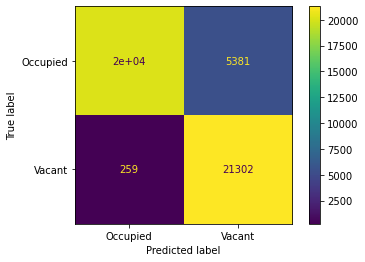

Cloudy-Testing bs=33 vt=0.32
Using OccupancyDetectorBorders
Selected 269 files
Processing 269 files with 10 workers


100%|██████████| 269/269 [00:51<00:00,  5.26it/s]

Precision: 0.959
specificity: 0.924
Recall: 0.961
F1 Score: 0.960
Accuracy: 0.948


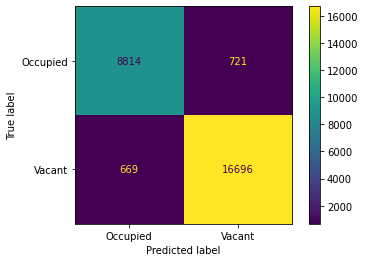

Rainy-Testing bs=33 vt=0.32
Using OccupancyDetectorBorders
Selected 169 files
Processing 169 files with 10 workers


100%|██████████| 169/169 [00:27<00:00,  6.04it/s]

Precision: 0.880
specificity: 0.942
Recall: 0.871
F1 Score: 0.876
Accuracy: 0.919


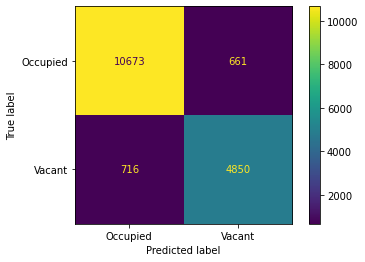

Test & Sunny & 33 & 0.32 & 0.798 & 0.789 & 0.988 & 0.883 & 0.880Test & Cloudy & 33 & 0.32 & 0.959 & 0.924 & 0.961 & 0.960 & 0.948Test & Rainy & 33 & 0.32 & 0.880 & 0.942 & 0.871 & 0.876 & 0.919


In [8]:
parking_id = 'PUCPR'
training = False
training_str = 'Training' if training else 'Testing'
save_dst = 'E:\\OneDrive - UNIVERSIDAD DE HUELVA\\TFG\\VisionParkDetect\\test\\bordersDetector\\'
detection_params=DetectionParams()
detection_params.at_method = cv.ADAPTIVE_THRESH_GAUSSIAN_C
detection_params.at_blockSize = 33
detection_params.vacant_threshold = 0.32

weather_list = ['Sunny', 'Cloudy', 'Rainy']
all_latex=""
testing_metrics = dict()

for weather in weather_list:
    row_name = f'{weather}-{training_str} bs={detection_params.at_blockSize} vt={detection_params.vacant_threshold}'
    print(row_name)
    testing_metrics[row_name]=test_parking(parking_id, weather, detection_params=detection_params, process_batch=True, training=training)
    all_latex += testing_metrics[row_name].to_latex("Test", weather, detection_params.at_blockSize, detection_params.vacant_threshold)

print(all_latex)

Sunny-Testing bs=33 vt=0.27
Using OccupancyDetectorBorders
Selected 471 files
Processing 471 files with 10 workers


100%|██████████| 471/471 [01:17<00:00,  6.04it/s]

Precision: 0.878
specificity: 0.890
Recall: 0.938
F1 Score: 0.907
Accuracy: 0.912


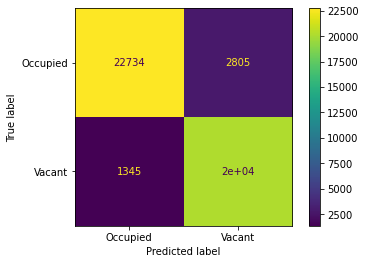

Test & Sunny & 33 & 0.27 & 0.878 & 0.890 & 0.938 & 0.907 & 0.912
Cloudy-Testing bs=33 vt=0.32
Using OccupancyDetectorBorders
Selected 269 files
Processing 269 files with 10 workers


100%|██████████| 269/269 [01:01<00:00,  4.39it/s]

Precision: 0.959
specificity: 0.924
Recall: 0.961
F1 Score: 0.960
Accuracy: 0.948


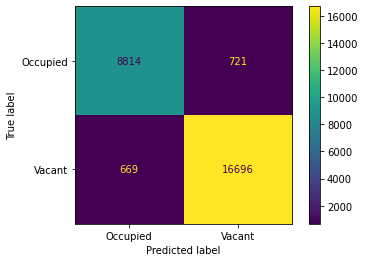

Test & Cloudy & 33 & 0.32 & 0.959 & 0.924 & 0.961 & 0.960 & 0.948
Rainy-Testing bs=53 vt=0.32
Using OccupancyDetectorBorders
Selected 169 files
Processing 169 files with 10 workers


100%|██████████| 169/169 [00:27<00:00,  6.06it/s]

Precision: 0.923
specificity: 0.970
Recall: 0.725
F1 Score: 0.812
Accuracy: 0.889


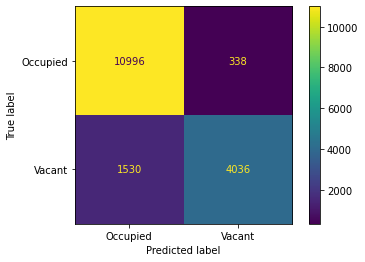

Test & Rainy & 53 & 0.32 & 0.923 & 0.970 & 0.725 & 0.812 & 0.889


In [7]:
test_parking_bs_vt('PUCPR', 33, 0.27, weather_list=['Sunny'])
test_parking_bs_vt('PUCPR', 33, 0.32, weather_list=['Cloudy'])
test_parking_bs_vt('PUCPR', 53, 0.32, weather_list=['Rainy'])

In [ ]:
target_metrics = dict()
weather='Cloudy'
    
file_pickle = f"test/bordersDetector/metrics_dict_vt_{parking_id}_{weather}_training.pickle"
with open(file_pickle, 'rb') as f:
    print(file_pickle)
    metrics_dict_vt = transpose_dict(pickle.load(f))

target_metrics[detection_params.at_blockSize] = metrics_dict_vt[detection_params.at_blockSize]



    # if show_metrics and save_fig_dst is not None :
    #     fig_dst = save_fig_dst + f'{parking_id}_{weather}_{training_test_folder}.png'
    
# PerformanceMetricsProviderSklearn.show_tpr_fpr(target_metrics, metrics_extra=testing_metrics)


from adjustText import adjust_text
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_auc_score, auc, average_precision_score
from matplotlib.font_manager import FontProperties
import numpy as np

metrics_dict_vt = target_metrics
metrics_extra = testing_metrics
fontP = FontProperties(family='sans-serif', size=8)
        # fontP.set_size('xx-small')

fig, ax = plt.subplots(2, 1, figsize=(5, 10), dpi=300, sharey=True)
first_param_str = "blockSize"
# plt.figure()
index = 0
all_tpr_list = list()
all_fpr_list = list()
all_precision_list = list()

for vt, metrics_dict_diff in metrics_dict_vt.items():
    # if vt != 0.3:
    #     continue

    tpr_list = list()
    fpr_list = list()
    precision_list = list()
    diff_list = list()
    real_list = list()
    predicted_list = list()
    for diff, metrics in metrics_dict_diff.items():
        tpr_list.append(metrics.recall)
        fpr_list.append(1 - metrics.specificity)
        precision_list.append(metrics.precision)
        diff_list.append(diff)
        real_list = real_list + metrics.real
        predicted_list = predicted_list + metrics.predicted

    auc = round(roc_auc_score(real_list, predicted_list), 3)
    ap = round(average_precision_score(real_list, predicted_list), 3)

    all_tpr_list = all_tpr_list + tpr_list
    all_fpr_list = all_fpr_list + fpr_list
    all_precision_list = all_precision_list + precision_list

    # ROC CURVE
    li = zip(*[fpr_list, tpr_list])
    ax[0].plot(*zip(*li), linestyle='--', marker='o',
                label=f'{index}: {weather}-Training bs={vt} AUC={auc:.3f}')

    # PR CURVE
    li_recall = zip(*[tpr_list, precision_list])
    ax[1].plot(*zip(*li_recall), linestyle='--', marker='o',
                label=f'{index}: {weather}-Training bs={vt} AP={ap:.3f}')
    
    index += 1

# Optional: plot extra metrics
if metrics_extra is not None:
    cdict = {1: 'orange', 2: 'gray', 3: 'blue'} 
    for label, metrics in metrics_extra.items():
        tpr = metrics.recall
        fpr = 1 - metrics.specificity
        precision = metrics.precision

        # ROC CURVE
        # li = zip(*[fpr, tpr])
        ax[0].scatter(fpr, tpr, marker='o', c=cdict[index],
                    label=f'{index}: {label}', zorder=10)

        # PR CURVE
        # li_recall = zip(*[tpr, precision])
        ax[1].scatter(tpr, precision, marker='o', c=cdict[index],
                    label=f'{index}: {label}', zorder=10)

        index += 1

# Set fixed x and y axis limits and ticks
for axi in ax:
    axi.set_xlim([-0.025, 1.025])
    axi.set_ylim([-0.025, 1.025])
    axi.set_xticks(np.arange(0, 1.1, 0.1))
    axi.set_yticks(np.arange(0, 1.05, 0.05))
    axi.xaxis.set_major_locator(plt.MultipleLocator(0.1))
    axi.yaxis.set_major_locator(plt.MultipleLocator(0.05))
    axi.grid(color='gray', linestyle='--', linewidth=0.5)
    axi.legend(loc='lower right', prop=fontP)
    axi.tick_params(axis='both', labelsize=6)
    



plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=1,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.2)

# Graph 1: FPR-TPR
plt.subplot(2, 1, 1)
# fig.suptitle(f'{parking_id}-{weather}')
ax[0].set_title('ROC Curve')
ax[0].set_xlabel('False positive rate (1 - Specificity)', fontsize=8)
ax[0].set_ylabel('True positive rate (Recall)', fontsize=8)

texts = [plt.text(fpr_list[i], tpr_list[i], diff_list[i], size=8)
            for i in range(len(fpr_list))]
adjust_text(texts, arrowprops={
            'arrowstyle': '->'}, expand_points=(1.1, 4.5), x=all_fpr_list, y=all_tpr_list)

plt.plot(0, 1, marker='x', c='black',
            label='Perfect classifier')


# Graph 2: Recall-TPR
plt.subplot(2, 1, 2)
ax[1].set_title('PR Curve')
ax[1].set_xlabel('True positive rate (Recall)', fontsize=8)
ax[1].set_ylabel('Precision', fontsize=8)

texts = [plt.text(tpr_list[i], precision_list[i], diff_list[i], size=8)
            for i in range(len(fpr_list))]
adjust_text(texts, arrowprops={
            'arrowstyle': '->'}, expand_points=(1.1, 4.5), x=all_tpr_list, y=all_precision_list)

plt.plot(1, 1, marker='x', c='black',
            label='Perfect classifier')



plt.show()


In [ ]:
parking_id = 'UFPR05'
training = False
training_str = 'Training' if training else 'Testing'
save_dst = 'E:\\OneDrive - UNIVERSIDAD DE HUELVA\\TFG\\VisionParkDetect\\test\\bordersDetector\\'
detection_params=DetectionParams()
detection_params.at_method = cv.ADAPTIVE_THRESH_GAUSSIAN_C
detection_params.at_blockSize = 61
detection_params.vacant_threshold = 0.30
detection_params.show_imshow =True


weather_list = ['Cloudy']

for weather in weather_list:
    row_name = f'{parking_id}-{weather} {training_str}'
    print(row_name)
    metrics = test_parking(parking_id, weather, detection_params=detection_params, process_batch=False, training=training)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load sample images
img1 = plt.imread('test/bordersDetector/PUCPR_Sunny_training.png')
img2 = plt.imread('test/bordersDetector/PUCPR_Cloudy_training.png')
img3 = plt.imread('test/bordersDetector/PUCPR_Rainy_training.png')

# Create a 1x3 subplot grid
fig, axs = plt.subplots(1, 3,figsize=(10, 10), dpi=600)

# Plot images in each subplot
axs[0].imshow(img1)
axs[0].set_title('PUCPR-Sunny')
axs[1].imshow(img2)
axs[1].set_title('PUCPR-Cloudy')
axs[2].imshow(img3)
axs[2].set_title('PUCPR-Rainy')

for axi in axs:
    axi.axis('off')

# Show the plot
plt.show()
plt.savefig('images.png', facecolor='white',)


In [25]:
def merge_dataframes(dataframes, ids):
    merged_df = pd.concat(dataframes, ignore_index=True)
    merged_df.insert(loc=0, column='Parking', value=ids)
    return merged_df

ids = list()
for p in ['UFPR04', 'UFPR05', 'PUCPR']:
    for _ in range(6):
        ids.append(p)

df_merged = merge_dataframes(dfs, ids)
display(df_merged)

,Parking,Weather,bs,vt,AUC,Dist Curve,Dist,Precision,Specificity,Recall,F1,Accuracy
0,UFPR04,Sunny,33,0.30,0.588,ROC,0.148,0.856,0.882,0.910,0.883,0.894
1,UFPR04,Sunny,33,0.29,0.588,PR,0.169,0.882,0.909,0.879,0.881,0.896
2,UFPR04,Cloudy,33,0.30,0.588,ROC,0.148,0.909,0.849,0.881,0.895,0.869
3,UFPR04,Cloudy,33,0.31,0.588,PR,0.144,0.892,0.812,0.905,0.898,0.871
4,UFPR04,Rainy,33,0.30,0.588,ROC,0.148,0.901,0.789,0.895,0.898,0.861
5,UFPR04,Rainy,33,0.31,0.588,PR,0.143,0.887,0.750,0.912,0.899,0.861
6,UFPR05,Sunny,53,0.36,0.596,ROC,0.171,0.841,0.875,0.883,0.861,0.878
7,UFPR05,Sunny,53,0.35,0.596,PR,0.196,0.860,0.895,0.862,0.861,0.881
8,UFPR05,Cloudy,53,0.36,0.596,ROC,0.171,0.839,0.884,0.865,0.852,0.877
9,UFPR05,Cloudy,53,0.35,0.596,PR,0.196,0.866,0.908,0.847,0.856,0.883


In [100]:
def add_multirows(table_str):
    lines = table_str.split('\n')
    out_lines = []
    prev_parking = None
    prev_weather = None
    for i, line in enumerate(lines):
        if i < 4 or i>21:  # skip header row
            out_lines.append(line)
            continue
        
        cols = line.split(' & ')

        parking = cols[0]
        weather = cols[1]
        
        cols.pop(0)
        cols.pop(0)
        inserted = False
        if parking != prev_parking:
            out_lines.append('\\midrule\\midrule \n \\multirow{6}[2]{*}{'+ parking +'} & \\multirow{2}[2]{*}{'+ weather +'} &')
            inserted = True
        elif weather != prev_weather:
            out_lines.append('\cmidrule{2-12}\n & \\multirow{2}[2]{*}{'+ weather + '} &')
            inserted = True

        out_lines.append(' & '.join(cols))
        
        if not inserted:
            out_lines[-1] ='& &' + out_lines[-1]
        
        prev_parking = parking
        prev_weather = weather
    return '\n'.join(out_lines)



print(add_multirows(table_str))


\begin{tabular}{llrrrlrrrrrr}
\toprule
Parking & Weather &  bs &   vt &   AUC & Dist Curve &  Dist &  Precision &  Specificity &  Recall &    F1 &  Accuracy \\
\midrule
\midrule\midrule 
 \multirow{6}[2]{*}{ UFPR04} & \multirow{2}[2]{*}{  Sunny} &
 33 & 0.30 & 0.588 &        ROC & 0.148 &      0.856 &        0.882 &   0.910 & 0.883 &     0.894 \\
& & 33 & 0.29 & 0.588 &         PR & 0.169 &      0.882 &        0.909 &   0.879 & 0.881 &     0.896 \\
\cmidrule{2-12}
 & \multirow{2}[2]{*}{ Cloudy} &
 33 & 0.30 & 0.588 &        ROC & 0.148 &      0.909 &        0.849 &   0.881 & 0.895 &     0.869 \\
& & 33 & 0.31 & 0.588 &         PR & 0.144 &      0.892 &        0.812 &   0.905 & 0.898 &     0.871 \\
\cmidrule{2-12}
 & \multirow{2}[2]{*}{  Rainy} &
 33 & 0.30 & 0.588 &        ROC & 0.148 &      0.901 &        0.789 &   0.895 & 0.898 &     0.861 \\
& & 33 & 0.31 & 0.588 &         PR & 0.143 &      0.887 &        0.750 &   0.912 & 0.899 &     0.861 \\
\midrule\midrule 
 \multirow{6}[2]{*}{ 